In [1]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

import utils
import vision_transformer as vits
import time
import imageio

import pandas as pd

import re
from datetime import datetime, timezone
from datetime import timedelta

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# 1. Read Videos and split

In [6]:

def parse_to_local_datetime(url):
    m = re.search(r'\d{8}T\d{6}', url)
    date_string = m.group(0)
    format = "%Y%m%dT%H%M%S"
    return datetime.strptime(date_string, format).replace(tzinfo=timezone.utc).astimezone(tz=None)

def resize_jacks(img):
    assert img.shape == (720, 1280, 3), f'unexpected shape {img.shape} found'
    return img[400:580,0:1200,:]

directory = '/Users/lukethomas/Desktop/surf'
wr_dir = './data/images/'
frame_time = []
fns = []
for filename in os.listdir(directory):
    if re.search(r'\d{8}T\d{6}', filename):
        vfn = os.path.join(directory, filename)
        vid = imageio.get_reader(vfn)
        fps = vid.get_meta_data()['fps']
        start_time = parse_to_local_datetime(vfn)
        SecPerMin = 60
        vid_len = int(vid.get_meta_data()['duration']*fps)
        frame_idx = [i for i in range(vid_len) if i%(fps*SecPerMin) == 0]
        for i in frame_idx:
            try:
                fn = wr_dir + str(start_time + timedelta(seconds = i/fps))+'.png'
                if os.path.isfile(fn): #check if already done
                    fns.append(fn)
                    frame_time.append(start_time + timedelta(seconds = i/fps))
                    continue
                else:
                    tmp = resize_jacks(vid.get_data(i)) #check if works first
                    imageio.imwrite(fn, tmp)
                    fns.append(fn)
                    frame_time.append(start_time + timedelta(seconds = i/fps))
            except:
                print('something went wrong')

len(fns)

something went wrong
something went wrong


979

In [7]:
print(len(fns), len(frame_time))

979 979


In [8]:
df = pd.DataFrame({'filename': fns, 'time': frame_time})
df

,filename,time
0,./data/images/2021-08-11 16:34:34-07:00.png,2021-08-11 16:34:34-07:00
1,./data/images/2021-08-11 16:35:34-07:00.png,2021-08-11 16:35:34-07:00
2,./data/images/2021-08-11 16:36:34-07:00.png,2021-08-11 16:36:34-07:00
3,./data/images/2021-08-11 16:37:34-07:00.png,2021-08-11 16:37:34-07:00
4,./data/images/2021-08-11 16:38:34-07:00.png,2021-08-11 16:38:34-07:00
...,...,...
974,./data/images/2021-08-11 13:00:14-07:00.png,2021-08-11 13:00:14-07:00
975,./data/images/2021-08-11 13:01:14-07:00.png,2021-08-11 13:01:14-07:00
976,./data/images/2021-08-11 13:02:14-07:00.png,2021-08-11 13:02:14-07:00
977,./data/images/2021-08-11 13:03:14-07:00.png,2021-08-11 13:03:14-07:00


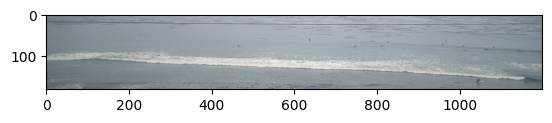

In [65]:
plt.imshow(plt.imread(fns[100]))
plt.show()

In [9]:
print('Earliest',str(min(df.time).time()), 'latest :', str(max(df.time).time())) 

Earliest 05:33:18 latest : 20:31:19


In [75]:
df.to_csv('jacks5to20.csv')